In [31]:
import torch #type: ignore
import torch.nn as nn #type: ignore
import matplotlib.pyplot as plt
from torchvision import datasets, transforms #type: ignore
from torch.utils.data import DataLoader #type: ignore


In [32]:
T=1000
beta=torch.linspace(1e-4,0.02,T)
alpha=1-beta
alpha_bar=torch.cumprod(alpha,dim=0)
def q_sample(x0,t,noise=None):
    if noise is None:
        noise=torch.randn_like(x0)
    device=x0.device
    alpha_bar=torch.cumprod(alpha,dim=0).to(device)
    alpha_bart=alpha_bar[t][(...,)+ (None,)*3]
    return torch.sqrt(alpha_bart)*x0+torch.sqrt(1-alpha_bart)*noise

def plot_noisy_image(x0,ts):
    plt.figure(figsize=(15,5))
    for i,t in enumerate(ts):
        xt=q_sample(x0,t)
        plt.subplot(1,len(ts),i+1)
        plt.imshow(xt.squeeze(),cmap='Blues')
        plt.title(f't={t}')
        plt.axis('off')
    plt.show()

In [33]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = torch.log(torch.tensor(10000, device=device)) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [34]:
class TimeAwareBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        # Time projection: turns the time vector into the same size as our channels
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x, t_emb):
        # 1. First convolution
        h = self.relu(self.conv1(x))
        
        # 2. Process time: Linear -> Add dimension to match (B, C, 1, 1)
        time_feat = self.relu(self.time_mlp(t_emb))
        time_feat = time_feat[(...,) + (None,) * 2] # This makes it (Batch, Out_Ch, 1, 1)
        
        # 3. Inject time! We add the time info to every pixel in the feature map
        h = h + time_feat
        
        # 4. Second convolution
        return self.relu(self.conv2(h))

In [35]:
class TinyUNet(nn.Module):
    def __init__(self):
        super().__init__()

        time_dim=256

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.GELU()
        )
        
        # 1. ENCODER (The Downward path)
        self.enc1 = TimeAwareBlock(1, 16,time_dim)   
        self.pool1 = nn.MaxPool2d(2)         
        
        self.enc2 = TimeAwareBlock(16, 32,time_dim)  
        self.pool2 = nn.MaxPool2d(2)         
        
        # 2. BOTTLENECK
        self.mid = TimeAwareBlock(32, 64,time_dim)   
        
        # 3. DECODER (The Upward path)
        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2) 
        self.dec2 = TimeAwareBlock(64, 32,time_dim) 
        
        self.up1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2) 
        self.dec1 = TimeAwareBlock(32, 16,time_dim)
        
        self.final_conv = nn.Conv2d(16, 1, kernel_size=1) 


    def forward(self, x, time):
        time_dim=self.time_mlp(time)
        # Step 1: Encoder
        e1 = self.enc1(x, time_dim)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1,time_dim)
        p2 = self.pool2(e2)
        
        # Step 2: Bottleneck
        m = self.mid(p2,time_dim)
        
        # Step 3: Decoder with Skip Connections
        
        u2= self.up2(m)
        x = torch.cat([u2, e2], dim=1)
        x = self.dec2(x, time_dim)
        
        u1= self.up1(x)
        x= torch.cat([u1,e1], dim=1)
        x= self.dec1(x,time_dim)
        x = self.final_conv(x) 
        return x

In [36]:
from torch.nn.functional import mse_loss
from torch.optim import Adam

In [37]:
def training_loss(model, x0):
    t= torch.randint(0,T,(x0.shape[0],),device=x0.device).long()
    noise= torch.randn_like(x0)
    xt= q_sample(x0,t,noise)
    predicted_noise= model(xt,t)
    return mse_loss(noise, predicted_noise)

In [38]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) 
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [39]:
Epochs=25
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
model= TinyUNet().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
for epoch in range(Epochs):
    total_loss=0
    for batch_idx, (images, _) in enumerate(train_loader):
        images = images.to(device)
        optimizer.zero_grad()
        loss = training_loss(model, images)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss= total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{Epochs}], Loss: {avg_loss:.4f}")
        


Epoch [1/25], Loss: 0.1190
Epoch [2/25], Loss: 0.0507
Epoch [3/25], Loss: 0.0448
Epoch [4/25], Loss: 0.0404
Epoch [5/25], Loss: 0.0388
Epoch [6/25], Loss: 0.0371
Epoch [7/25], Loss: 0.0356
Epoch [8/25], Loss: 0.0348
Epoch [9/25], Loss: 0.0337
Epoch [10/25], Loss: 0.0332
Epoch [11/25], Loss: 0.0327
Epoch [12/25], Loss: 0.0324
Epoch [13/25], Loss: 0.0321
Epoch [14/25], Loss: 0.0316
Epoch [15/25], Loss: 0.0314
Epoch [16/25], Loss: 0.0311
Epoch [17/25], Loss: 0.0312
Epoch [18/25], Loss: 0.0305
Epoch [19/25], Loss: 0.0304
Epoch [20/25], Loss: 0.0304
Epoch [21/25], Loss: 0.0300
Epoch [22/25], Loss: 0.0299
Epoch [23/25], Loss: 0.0297
Epoch [24/25], Loss: 0.0300
Epoch [25/25], Loss: 0.0301


In [40]:
@torch.no_grad()
def ddpm_reverse_step(model, xt, t):
    """
    Moves from x_t to x_{t-1} using the model's noise prediction.
    """
    # 1. Setup constants (Broadcasting to match xt shape: [B, 1, 28, 28])
    device = xt.device
    
    # Ensure constants are on the same device as the image
    b_t = beta.to(device)[t][(...,) + (None,) * 3]
    a_t = alpha.to(device)[t][(...,) + (None,) * 3]
    ab_t = alpha_bar.to(device)[t][(...,) + (None,) * 3]
    
    # 2. Model predicts the noise (epsilon_theta)
    # We pass the noisy image and the current timestep
    pred_noise = model(xt, t)
    
    # 3. Calculate the mean of the distribution (the 'denoised' part)
    # Formula: x_{t-1} = 1/sqrt(a_t) * (x_t - ( (1-a_t)/sqrt(1-ab_t) ) * pred_noise)
    model_mean = (1 / torch.sqrt(a_t)) * (
        xt - ( (1 - a_t) / torch.sqrt(1 - ab_t) ) * pred_noise
    )
    
    # 4. If we are at the very last step (t=0), we don't add noise
    if t[0] == 0:
        return model_mean
    else:
        # 5. Add random noise (the stochastic part)
        # This keeps the generation diverse
        z = torch.randn_like(xt)
        sigma_t = torch.sqrt(b_t) # Standard variance is sqrt(beta_t)
        return model_mean + sigma_t * z

In [41]:
@torch.no_grad()
def sample_steps(model, n=1):
    model.eval()
    img = torch.randn((n, 1, 28, 28), device=device)
    frames = [] # To store intermediate steps
    
    for i in reversed(range(0, T)):
        t = torch.full((n,), i, device=device, dtype=torch.long)
        img = ddpm_reverse_step(model, img, t)
        
        # Capture every 20th step (plus the very first and last)
        if i % 20 == 0 or i == T-1 or i == 0:
            # Denormalize and move to CPU for plotting
            frame = (img.clamp(-1, 1) + 1) / 2
            frames.append(frame[0].cpu().squeeze().numpy())
            
    return frames

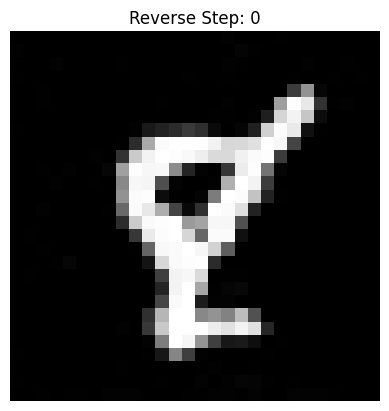

In [43]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


# 1. Generate the frames
frames = sample_steps(model,n=4)

# 2. Setup the figure
fig, ax = plt.subplots()
ax.axis('off')
im = ax.imshow(frames[0], cmap="gray")

# 3. Animation update function
def update(idx):
    im.set_array(frames[idx])
    ax.set_title(f"Reverse Step: {1000 - (idx * 20)}")
    return [im]

# 4. Create and Save
ani = FuncAnimation(fig, update, frames=len(frames), interval=50, blit=True)
ani.save("denoising_process.gif", writer='pillow')
HTML(ani.to_jshtml())
# plt.show()